In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader,TensorDataset
from gensim.models import Word2Vec

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [42]:
class RNNVAE(nn.Module):
    def __init__(self, embedding_matrix, word2idx, idx2word, hidden_dim, latent_dim, num_layers, sos_token, vocab_size):
        super(RNNVAE, self).__init__()

        self.embedding_dim = embedding_matrix.shape[1]
        self.word2idx = word2idx
        self.idx2word = idx2word
        self.sos_token = sos_token
        
        self.embedding = nn.Embedding.from_pretrained(embedding_matrix, freeze = True)
        self.layer_norm = nn.LayerNorm(self.embedding_dim)

        self.encoder = nn.RNN(self.embedding_dim, hidden_dim, num_layers, batch_first = True)
        self.decoder = nn.RNN(self.embedding_dim, hidden_dim, num_layers, batch_first = True)

        self.fc_mu = nn.Linear(hidden_dim, latent_dim)  
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.fc_hidden = nn.Linear(latent_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    
    def forward(self, x):
        embedded = self.embedding(x)
        embedded = self.layer_norm(embedded)

        _, hn = self.encoder(embedded)

        mu = self.fc_mu(hn)
        logvar = self.fc_logvar(hn)
        z = self.reparametrization(mu, logvar)

        z = self.fc_hidden(z)

        output, _ = self.decoder(embedded, z)

        output = self.fc(output)
        
        return output, mu, logvar
    


    def reparametrization(self, mu, log_var):
        ''' Reparametrization trick
        
        Inputs
        -------
        mu : torch tensor
        log_var : torch tensor
            
        
        Returns
        -------
        mu + eps*std : torch tensor with the same shape as mu and log_var'''
        
        std = torch.exp(0.5*log_var)
        eps = torch.randn_like(std)

        return mu + eps*std


    def reconstruction(self, x):
        ''' Reconstruction function for inference
        Input
        -------
        x : torch tensor with shape [Batch_size, Sequence_length], input sequence
            
        
        Returns
        -------
        outputs : torch tensor with shape [Batch_size, Sequence_length, Embedding_dim], the reconstructed sentence'''
        self.eval()
        with torch.no_grad():

            # embedding input and GRU encoder pass
            embedded_input = self.embedding(x)
            embedded_input = self.layer_norm(embedded_input)
            _, hn = self.encoder(embedded_input)
            
            # computing mu and log_var for style and content space
            mu_s = self.fc_mu(hn)
            logvar_s = self.fc_logvar(hn)

            # reparametrization for style and content
            z = self.reparametrization(mu_s, logvar_s)

            # concatenating style and content space
            z = self.hidden(z)

            # prepare sos_token for the decoder
            sos_token = self.sos_token.repeat(x.size(0),1)
            sos_token = self.embedding(sos_token)
            sos_token = self.layer_norm(sos_token)


            # decoder pass where the input is the previous output
            output = sos_token
            for _ in range(x.shape[1]):
                outputs, _ = self.decoder(output, z)
                outputs = self.fc(outputs)
                next_token = torch.argmax(F.softmax(outputs[:,-1,:], dim = -1), dim=-1)
                next_token = self.embedding(next_token)
                output = torch.cat((output, next_token.unsqueeze(1)), dim=1)
        
        
        return outputs
    

    def sample(self, hn, len_sample):
        self.eval()
        with torch.no_grad():
            mu_s = self.fc_mu(hn)
            logvar_s = self.fc_logvar(hn)

            # reparametrization for style and content
            z = self.reparametrization(mu_s, logvar_s)

            # concatenating style and content space
            z = self.hidden(z)

            # prepare sos_token for the decoder
            sos_token = self.sos_token.repeat(x.size(0),1)
            sos_token = self.embedding(sos_token)
            sos_token = self.layer_norm(sos_token)


            # decoder pass where the input is the previous output
            output = sos_token
            for _ in range(len_sample):
                outputs, _ = self.decoder(output, z)
                outputs = self.fc_out(outputs)
                next_token = torch.argmax(F.softmax(outputs[:,-1,:], dim = -1), dim=-1)
                next_token = self.embedding(next_token)
                output = torch.cat((output, next_token.unsqueeze(1)), dim=1)

        return outputs

In [3]:
def divide_text(text, sequence_length):
    ''' Function dividing text in order to feed the Word2vec model
    
    Inputs
    ----------
    text : text corpus from a file
    sequence_length : int
    
    
    Returns
    ----------
    output_text : 2D list of words with shape [text_length/sequence_length, sequence_length]'''

    words = text.split()
    grouped_words = [' '.join(words[i:i+sequence_length]) for i in range(0,len(words),int(sequence_length/2))]  
    output_text = [grouped_words[i].split() for i in range(len(grouped_words))]

    return output_text

In [4]:
def divide_text_equal_seq_length(text, sequence_length):
    ''' Function dividing text in order to feed the Word2vec model
    
    Inputs
    ----------
    text : text corpus from a file
    sequence_length : int
    
    
    Returns
    ----------
    output_text : 2D list of words with shape [text_length/sequence_length, sequence_length]'''

    words = text.split()
    grouped_words = [' '.join(words[i:i+sequence_length]) for i in range(0,len(words),int(sequence_length/2))]  
    output_text = [grouped_words[i].split() for i in range(len(grouped_words)) if len(grouped_words[i].split()) == sequence_length]

    return output_text

In [39]:
def custom_dataset(txt_file : str, sequence_length, embedding_dim, batch_size, training_fraction):
    ''' Function creating dataset
    
    Inputs
    ----------
    file1 : str, name of the file containing the first corpus
    file2 : str, name of the file containing the second corpus
    file3 : str, name of the file containing the third corpus
    sequence_length : int
    embedding_dim : int, number of dimension for the embedded words using Word2vec model
    batch_size : int
    training_fraction : float, fraction of training data
    
    
    Returns
    ----------
    dataloader_train : istance of torch.utils.data.Dataloader, training data
    dataloader_val : istance of torch.utils.data.Dataloader, validation data
    embedding_dim : int
    embedding_matrix : 2d torch tensor matrix from word2vec embedding
    word2vec : trained Word2vec model
    idx2word : dictionary from indices to words
    word2idx : dictionart from words to indices
    vocab_size : int, number of unique tokens
    style0_test : torch tensor containing every test data belonging to first style
    style1_test : torch tensor containing every test data belonging to second style
    style3_test : torch tensor containing every test data belonging to third style'''

    # reading the two corpus
    with open(txt_file, 'r', encoding='utf-8') as f:
        text = f.read()


    text = '<sos> ' + text
    # divide the whole text to feed the Word2vec model
    divided_text = divide_text(text, sequence_length)

    # training the Word2vec model with the whole corpus
    word2vec = Word2Vec(divided_text, vector_size = embedding_dim, window = sequence_length, min_count=1, workers=4, epochs = 30)
    word2vec.train(divided_text, total_examples=word2vec.corpus_count, epochs=word2vec.epochs)

    # Get the embedding dimension
    embedding_dim = word2vec.wv.vector_size

    # Prepare the embedding matrix
    vocab_size = len(word2vec.wv)
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    word2idx = {word: idx for idx, word in enumerate(word2vec.wv.index_to_key)}
    idx2word = {idx: word for idx, word in enumerate(word2vec.wv.index_to_key)}

    # creating the embedding matrix from the trained Word2vec model
    for word, idx in word2idx.items():
        embedding_matrix[idx] = word2vec.wv[word]

    
    embedding_matrix = torch.tensor(embedding_matrix, dtype=torch.float32)


    
    dataset = divide_text_equal_seq_length(text, sequence_length)
    dataset = torch.LongTensor([[word2idx[char] for char in dataset[i]] for i in range(len(dataset))])


    train_data = dataset[ : int(training_fraction * dataset.shape[0])]
    val_data = dataset[int(training_fraction * dataset.shape[0]) : ]

    dataset_train = TensorDataset(train_data)

    # Create a training DataLoader with shuffling enabled
    dataloader_train = DataLoader(dataset_train, batch_size = batch_size, shuffle = True)


    dataset_val = TensorDataset(val_data)

    # Create a validation DataLoader with shuffling enabled
    dataloader_val = DataLoader(dataset_val, batch_size = batch_size, shuffle = True)
    
    
    return dataloader_train, dataloader_val, embedding_dim, embedding_matrix, word2vec, idx2word, word2idx, vocab_size

In [52]:
def vae_loss(recon_x, x, mu, logvar, l_kl = 0.05, loss_fn = nn.CrossEntropyLoss()):
    ''' Function computing loss function for classification
    
    Inputs
    ---------
    pred_labels : 3D torch tensor with predicted labels with shape [1, Batch size, 3]
    labels : 2D torch tensor with ground truth labels with shape [Batch size, 3]
    
    Returns
    ---------
    L : float, loss value '''

    L = loss_fn(recon_x.reshape((recon_x.size(0)*recon_x.size(1),recon_x.size(2))), x.view(-1))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return L + l_kl * KLD

In [50]:
def training(model, train_loader, val_loader, num_epochs, lr = 4e-4, title = 'Training'):
    ''' Training function
    
    Input
    --------
    model : istance of a CNNClassifier, RNNClassifier, GRUClassifier, LSTMClassifier or TClassifier
    train_loader : istance of torch Dataloader with training data and labels
    val_loader : istance of torch Dataloader with validation data and labels
    num_epochs : int, number of epochs
    lr : float, learning rate for Adam optimizer
    title : str, Title of the matplot figure
    
    Returns
    --------
    train_losses : list with train loss values '''

    params = list(model.parameters())

    # Optimizer
    optimizer = torch.optim.Adam(params, lr = lr)

    train_losses = []
    val_losses = []

    # For loop over epochs
    for epoch in tqdm(range(num_epochs)):
        train_loss = 0.0
        average_loss = 0.0
        val_loss = 0.0
        average_val_loss = 0.0

        # For loop for every batch
        for  i, (inputs) in enumerate(train_loader):
            inputs[0] = inputs[0].to(device)
            

            optimizer.zero_grad()
            

            # forward pass through classifier
            recon_x, mu, logvar = model(inputs[0])
    
            # comuting training loss
            loss = vae_loss(recon_x.to(device),
                            inputs[0].to(device),
                            mu.to(device),
                            logvar.to(device))
            
            loss.backward()
            train_loss += loss.item()


            optimizer.step()
            
            if (i + 1) % 5000 == 0:
                print(f'Train Epoch: {epoch+1} [{i * len(inputs)}/{len(train_loader.dataset)} ({100. * i / len(train_loader):.0f}%)]\tLoss: {loss.item() / len(inputs):.6f}')
        
        
        # Validation
        with torch.no_grad():
            for i, (inputs) in enumerate(val_loader):
                inputs[0] = inputs[0].to(device)
    

                # forward pass through classifier
                recon_x, mu, logvar = model(inputs[0])
                
                
                # comuting validation loss
                val_loss_tot = vae_loss(recon_x.to(device),
                                        inputs[0].to(device),
                                        mu.to(device),
                                        logvar.to(device))
                
                val_loss += val_loss_tot.item()


                
                if (i + 1) % 5000 == 0:
                    print(f'Train Epoch: {epoch+1} [{i * len(inputs)}/{len(val_loader.dataset)} ({100. * i / len(val_loader):.0f}%)]\tLoss: {val_loss_tot.item() / len(inputs):.6f}')
            
            
        # Computing average training and validation loss
        average_loss = train_loss / len(train_loader.dataset)
        train_losses.append(average_loss)

        average_val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(average_val_loss)
        
        # printing average training and validation losses
        print(f'====> Epoch: {epoch+1} Average train loss: {average_loss:.4f}, Average val loss: {average_val_loss:.4f}')
    

    # Plotting training and validation curve at the end of the for loop 
    plt.plot(np.linspace(1,num_epochs,len(train_losses)), train_losses, c = 'darkcyan',label = 'train')
    plt.plot(np.linspace(1,num_epochs,len(val_losses)), val_losses, c = 'orange',label = 'val')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(title)
    plt.show()

    return train_losses

In [40]:
sequence_length = 25
batch_size = 64
embedding_dim = 200
hidden_dim = 256

In [41]:
train_loader, val_loader, embedding_dim, embedding_matrix, word2vec, idx2word, word2idx, vocab_size = custom_dataset('divina_commedia.txt',
                                                                                                                    sequence_length,
                                                                                                                    embedding_dim,
                                                                                                                    batch_size,
                                                                                                                    0.9)

print('total number of training samples: ', len(train_loader.dataset))
print('total number of validation samples: ', len(val_loader.dataset))
print('vocab size: ', vocab_size)

total number of training samples:  7619
total number of validation samples:  847
vocab size:  12761


In [53]:
vae = RNNVAE(embedding_matrix, word2idx, idx2word, hidden_dim, 136, 1, vocab_size)

In [54]:
model_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)

print('Total parameters: ', model_params)

Total parameters:  3619449


 20%|██        | 1/5 [00:27<01:51, 27.97s/it]

====> Epoch: 1 Average train loss: 0.1849, Average val loss: 0.0806


 40%|████      | 2/5 [00:57<01:27, 29.07s/it]

====> Epoch: 2 Average train loss: 0.0506, Average val loss: 0.0407


 60%|██████    | 3/5 [01:30<01:01, 30.68s/it]

====> Epoch: 3 Average train loss: 0.0279, Average val loss: 0.0302


 80%|████████  | 4/5 [02:03<00:31, 31.62s/it]

====> Epoch: 4 Average train loss: 0.0182, Average val loss: 0.0246


100%|██████████| 5/5 [02:36<00:00, 31.34s/it]

====> Epoch: 5 Average train loss: 0.0123, Average val loss: 0.0211


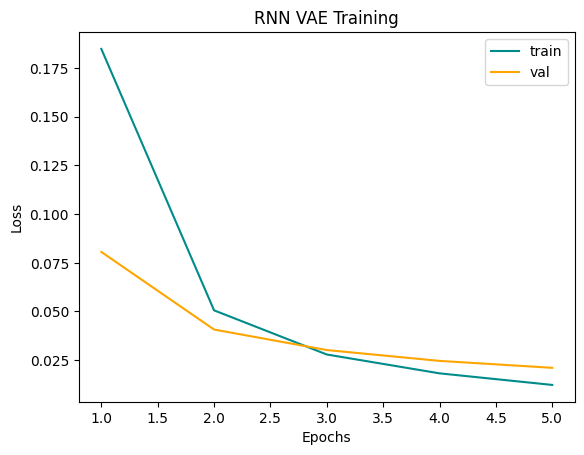

In [55]:
train_losses = training(vae, train_loader, val_loader, 5, lr = 4e-4, title = 'RNN VAE Training')